# **Importing all necessary libraries**

In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import cv2
import random
import os
from sklearn.model_selection import train_test_split

# **Setting random seed**

In [ ]:
seed=1234
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed(seed)

Random seed set as 1234


# **Preparing dataset**

In [ ]:
dataset= tfds.load('oxford_iiit_pet',split='train+test',shuffle_files=True)
ds_numpy=np.vstack(tfds.as_numpy(dataset))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2HAFCF/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete2HAFCF/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [ ]:
X=np.array(list(map(lambda x:x[0]['image'],ds_numpy)))
y=np.array(list(map(lambda x:x[0]['label'],ds_numpy)))
print(X.shape)
print(y.shape)

(7349,)
(7349,)


In [ ]:
img_size=128
n=X.shape[0]
X_=np.zeros(shape=(n,img_size,img_size,3),dtype='uint8')
i=0
for img in X:
    img=cv2.resize(img,(img_size,img_size))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    X_[i]=img
    i+=1

# **Visualizing some images from the dataset**

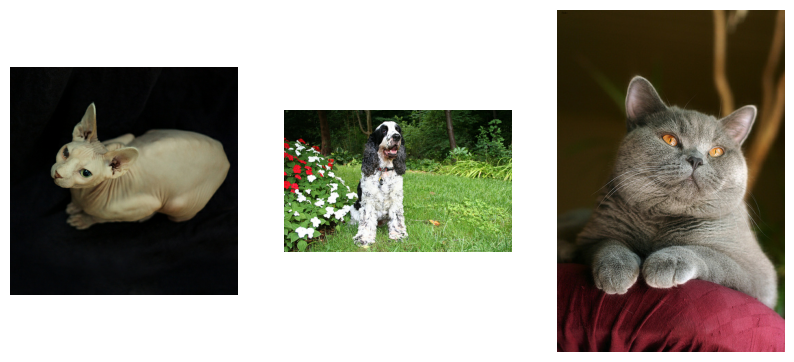

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,3,1)
ax.axis('off')
ax.imshow(X[0])
ax=fig.add_subplot(1,3,2)
ax.axis('off')
ax.imshow(X[1])
ax=fig.add_subplot(1,3,3)
ax.axis('off')
ax.imshow(X[2])
plt.show()

# **Analysing distribution of classes**

<function matplotlib.pyplot.show(close=None, block=None)>

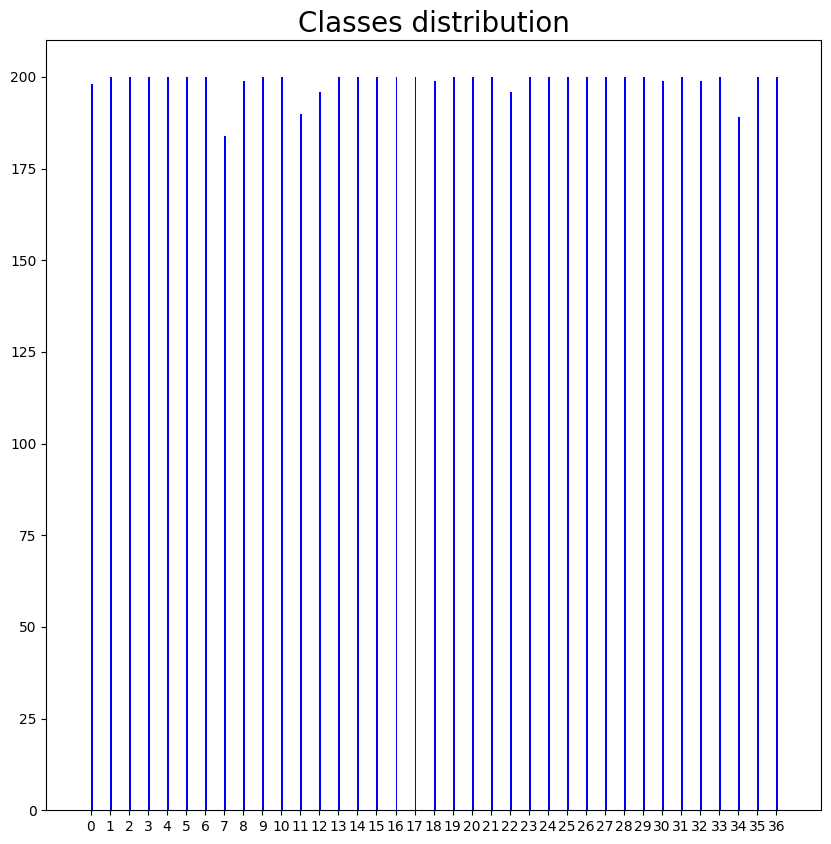

In [ ]:
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(1,1,1)
ax.set_title('Classes distribution',fontsize=20)
for i in np.unique(y):
    ax.hist(y[y==i],color='b')
plt.xticks([i for i in np.unique(y)])
plt.show

# **Processing dataset**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_,y,random_state=1,train_size=0.8)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,random_state=1,test_size=0.5)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(5879, 128, 128, 3)
(5879,)
(735, 128, 128, 3)
(735,)
(735, 128, 128, 3)
(735,)


In [ ]:
def zoom_image(image,margin):
    zoomed=image[margin:img_size-margin,margin:img_size-margin]
    zoomed=cv2.resize(zoomed,(img_size,img_size))
    return zoomed

In [ ]:
X_train=np.append(X_train,np.array([cv2.flip(image,1) for image in X_train]),axis=0)
y_train=list(y_train)
n=len(y_train.copy())
for i in range(n):
    y_train.append(y_train[i])
y_train=np.array(y_train)
X_train=np.append(X_train,np.array([zoom_image(image,10) for image in X_train]),axis=0)
y_train=list(y_train)
n=len(y_train.copy())
for i in range(n):
    y_train.append(y_train[i])
y_train=np.array(y_train)

In [ ]:
BATCH_SIZE=128
X_train=tf.convert_to_tensor(X_train)
print(X_train.shape)
y_train=tf.convert_to_tensor(y_train)
print(y_train.shape)
X_val=tf.convert_to_tensor(X_val)
print(X_val.shape)
y_val=tf.convert_to_tensor(y_val)
print(y_val.shape)
X_test=tf.convert_to_tensor(X_test)
print(X_test.shape)
y_test=tf.convert_to_tensor(y_test)
print(y_test.shape)
train_data=tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(BATCH_SIZE)
test_data=tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(BATCH_SIZE)

(23516, 128, 128, 3)
(23516,)
(735, 128, 128, 3)
(735,)
(735, 128, 128, 3)
(735,)


# **Learning model**

In [ ]:
EPOCHS=10
base_model=tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
for layers in base_model.layers:
    layers.trainable=False
model=tf.keras.Sequential([base_model,
                           tf.keras.layers.Dropout(0.125),
                           tf.keras.layers.Conv2D(filters=1024,kernel_size=(2,2),strides=(1,1),padding='same'),
                           tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                           tf.keras.layers.Dropout(0.25),
                           tf.keras.layers.Conv2D(filters=2048,kernel_size=(2,2),strides=(1,1),padding='same'),
                           tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(units=128,activation='relu'),
                           tf.keras.layers.Dense(units=37,activation='softmax')])
model.summary()
model.compile(tf.keras.optimizers.Adam(learning_rate=2e-5),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['Accuracy'],run_eagerly=True)
hist=model.fit(train_data,epochs=EPOCHS,validation_data=val_data)

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 4, 4, 512)         0         
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 1024)        2098176   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 1024)       0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 2, 2, 1024)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 2048)        83

# **Analysing model performance and saving model**

In [ ]:
test_=model.evaluate(test_data)
print(f'Test loss : {test_[0]}, Test accuracy : {test_[1]}')

6/6 [==============================] - 1s 126ms/step - loss: 1.3599 - Accuracy: 0.6694
Test loss : 1.3599135875701904, Test accuracy : 0.6693877577781677


In [ ]:
model.save_weights('/kaggle/working/weights.h5')

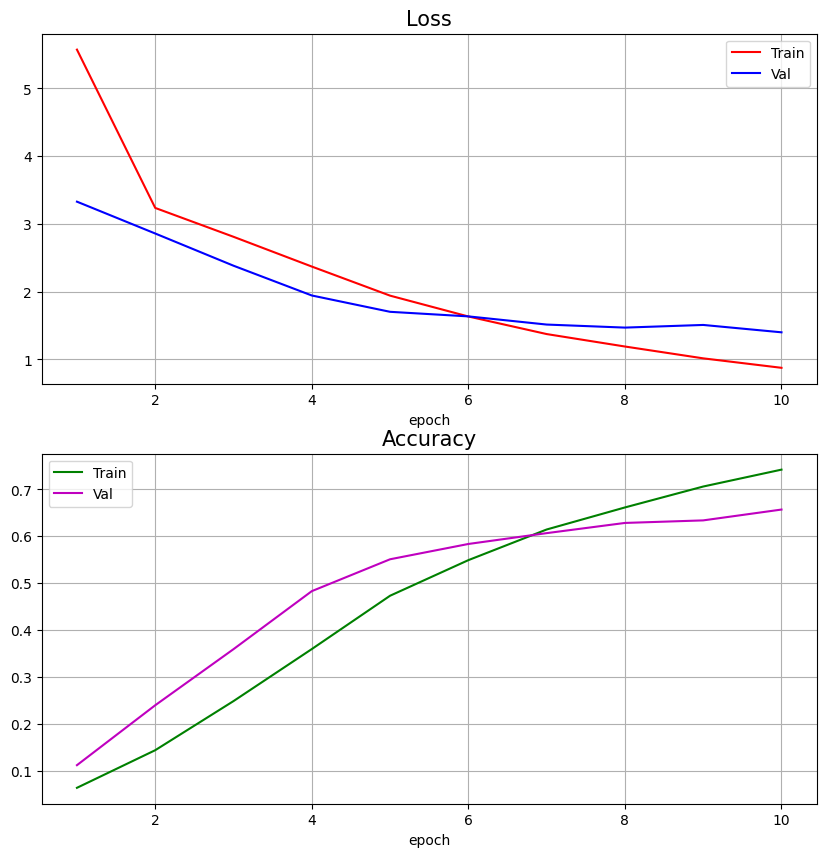

In [ ]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['Accuracy']
val_acc=hist.history['val_Accuracy']
epochs=[i for i in range(1,EPOCHS+1)]
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,1,1)
ax1.set_title('Loss',fontsize=15)
ax1.plot(epochs,train_loss,color='r',label='Train')
ax1.plot(epochs,val_loss,color='b',label='Val')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend()
ax2=fig.add_subplot(2,1,2)
ax2.set_title('Accuracy',fontsize=15)
ax2.plot(epochs,train_acc,color='g',label='Train')
ax2.plot(epochs,val_acc,color='m',label='Val')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend()
plt.show()

In [ ]:
base_model=tf.keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
for layers in base_model.layers:
    layers.trainable=False
model_=tf.keras.Sequential([base_model,
                           tf.keras.layers.Conv2D(filters=1024,kernel_size=(2,2),strides=(1,1),padding='same'),
                           tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                           tf.keras.layers.Conv2D(filters=2048,kernel_size=(2,2),strides=(1,1),padding='same'),
                           tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(units=128,activation='relu'),
                           tf.keras.layers.Dense(units=37,activation='softmax')])
model_.compile(tf.keras.optimizers.Adam(learning_rate=1e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['Accuracy'],run_eagerly=True)
model_.load_weights('/kaggle/working/weights.h5')
model_.evaluate(test_data)

6/6 [==============================] - 1s 126ms/step - loss: 1.3599 - Accuracy: 0.6694


[1.3599135875701904, 0.6693877577781677]